# Image Segmentation with Deep Learning

## Project Overview

This project implements a deep learning-based image segmentation model using PyTorch and the `segmentation_models_pytorch` library. The goal of the project is to perform **binary image segmentation**, where the task is to classify each pixel in an image as belonging to either the foreground (object of interest) or the background.

### Key Components:

1. **Model Architecture**:
   - The model used in this project is based on the **Unet** architecture, which is widely used for image segmentation tasks.
   - The Unet model employs an encoder-decoder structure with skip connections, enabling it to capture both spatial and contextual information.
   - The encoder can use pretrained models such as ResNet, and the decoder reconstructs the segmentation mask.

2. **Loss Functions**:
   - The project employs two primary loss functions for training the model:
     - **Binary Cross-Entropy with Logits Loss (`BCEWithLogitsLoss`)**: A standard loss function for binary classification tasks.
     - **Dice Loss**: A loss function that maximizes overlap between the predicted segmentation and the ground truth, which is especially useful for imbalanced datasets.

3. **Data Augmentation**:
   - The **Albumentations** library is used for data augmentation. It ensures that the same transformations (such as flipping, rotation, or scaling) are applied consistently to both the images and their corresponding segmentation masks.
   - This improves the model's robustness and generalization by exposing it to various forms of data distortions during training.

4. **Training and Evaluation**:
   - The model is trained using a defined number of **epochs**, with the training process optimizing the loss function using the **Adam optimizer**.
   - The training and validation loss are tracked to monitor performance, and the best-performing model (based on validation loss) is saved.
   - Evaluation is performed on a separate validation set, where the model's predictions are compared against the ground truth masks.

5. **Prediction**:
   - After training, the model can generate segmentation masks for unseen images. The predictions are obtained by applying a **sigmoid activation function** to the model’s output and thresholding the result to create binary masks.

### Project Highlights:
- **Efficient Model Training**: The model is trained using the Adam optimizer with adjustable learning rates.
- **Best Model Saving**: The model with the lowest validation loss is saved during training for later use.
- **Visualization**: Helper functions are used to visualize the original images, ground truth masks, and predicted segmentation masks side by side.

### Conclusion:
This project demonstrates the power of deep learning for pixel-wise classification in image segmentation. By using techniques such as Unet, data augmentation, and a combination of loss functions, the model is capable of accurately segmenting objects in images.


# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=7788fa19200dbf4d815a8c89b2d7250dcfa4ca6b0c6d294f0d95f0e8b5d762a5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=54001b1eeedf0d5568a5e3c96698e8af86a507766d7ec72575b249066b639ca4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 15.42 MiB/s, done.
Resolving deltas: 100% (3/3), done.


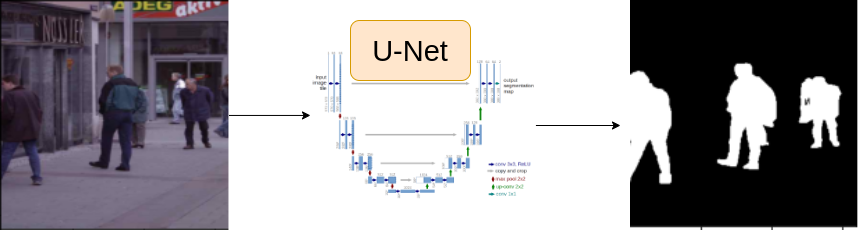

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'
# This is the number of times the entire dataset will pass through the model during training
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
# The batch size determines how many training samples will be processed at one time.
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
# This specifies that the model will use pre-trained weights from the ImageNet dataset.
WEIGHTS = 'imagenet'


In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[6]
image_path = row.images
mask_path = row.masks
# loads the image from the file path using OpenCV
image = cv2.imread(image_path)
# converts the image from BGR (the default color format in OpenCV) to RGB (the standard format used by most image processing libraries).
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# reads the segmentation mask as a grayscale image.
# OpenCV converts the image to a single-channel (1D) grayscale image
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


In [30]:
image.shape

torch.Size([3, 320, 320])

In [31]:
mask.shape

torch.Size([1, 320, 320])

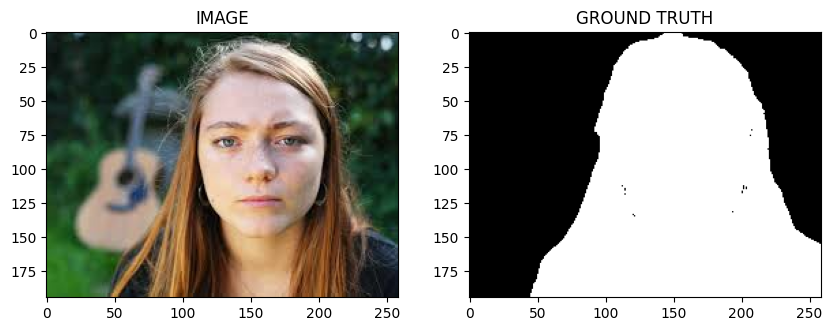

In [8]:
# f: A figure object is created that represents the entire drawing area or canvas and is used to control the global Settings of the graph, such as title, size, and so on.
# (ax1, ax2): Two sub-graph objects (axes objects), each corresponding to two sub-graphs
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 42)

In [10]:
train_df.shape

(232, 2)

In [11]:
valid_df.shape

(58, 2)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

Data enhancement does **not involve increasing the number of samples**, it simply generates multiple versions of random transformations for each sample in the original dataset to increase the robustness of the model in different scenarios

In [12]:
# Albumentations is commonly used for image augmentation, which helps improve the generalization of models by applying random transformations to the images during training.
import albumentations as A


In [37]:
def get_train_augs():
    # chain multiple augmentations together.
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)

    ],is_check_shapes=False)
def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ],is_check_shapes=False)


# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [46]:
class SegmentationDataset(Dataset):
    # The self.df stores the dataset, and self.augmentations stores any augmentations to be used.
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
    # This method returns the length of the dataset (i.e., the number of rows in the DataFrame df). This is necessary for PyTorch's DataLoader to know how many samples are in the dataset.
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # This selects the row from the DataFrame at the given index.
        row = self.df.iloc[idx]
        # The paths to the image and the corresponding segmentation mask are then extracted from the selected row.
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        # converts the image from OpenCV’s default BGR format to the more standard RGB format.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # reads the segmentation mask in grayscale mode (1 channel, 2D).
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # adds a channel dimension to the mask (making it 3D), which is common for masks in image segmentation tasks where the mask needs to have a shape of (height, width, 1).
        mask = np.expand_dims(mask, axis=-1)

        # If augmentations were provided during initialization, this block applies them to both the image and mask.
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # ensures that the data type is a 32-bit floating point, which is the standard data type for deep learning models.
        # The image and mask are transposed from the shape (H, W, C) (height, width, channels) to (C, H, W) (channels, height, width). This is required because PyTorch expects image tensors in the order of (channels, height, width).
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # normalizes
        # No rounding is needed because image pixel values are continuous and should not be forced into binary values (i.e., 0 or 1).
        image = torch.Tensor(image) / 255.0
        # The torch.round() function is used to ensure that the mask remains binary (0 or 1)
        # mask's pixel values are either 0 (background) or 255 (object)
        mask = torch.round(torch.Tensor(mask) / 255.0)
        # print(f"The shape of image is {image.shape}")
        # print(f"The shape of mask is {mask.shape}")

        return image, mask


In [47]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [34]:
trainset

In [48]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


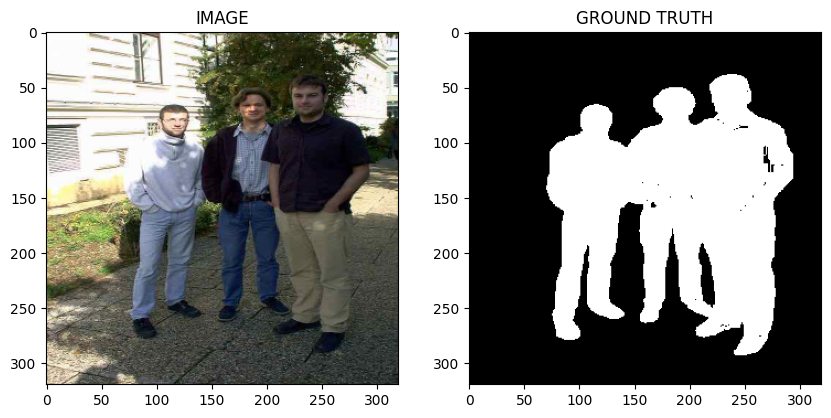

In [49]:
idx = 80
print(image.shape)  # Shape of the image
print(mask.shape)   # Shape of the mask

image, mask = trainset[idx]
helper.show_image(image, mask)



# Task 5 : Load dataset into batches

In [50]:
# DataLoader helps iterate through datasets in mini-batches, shuffling them, and optionally using multiprocessing to speed up the data loading process.
from torch.utils.data import DataLoader

In [51]:
# shuffle=True ensures that the data is shuffled at each epoch to improve training generalization.
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")


total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [52]:
# retrieve one batch of images and masks from the trainloader.
for image, mask in trainloader:
    break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [53]:
# used to define neural network modules and loss functions
from torch import nn
# simplifies working with common segmentation models like Unet, FPN, etc.
import segmentation_models_pytorch as smp
# It measures the overlap between the predicted segmentation and the ground truth mask.
from segmentation_models_pytorch.losses import DiceLoss


In [54]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            #  Indicates that pretrained weights (typically from ImageNet) will be used for the encoder.
            encoder_weights=WEIGHTS,
            # input has 3 channels (i.e., RGB images)
            in_channels=3,
            # the model predicts a single class output (for binary segmentation).
            classes=1,
            activation=None
        )
    def forward(self, images, masks=None):
        # The Unet model (self.arc) processes the input images and outputs the logits (unnormalized scores).
        logits = self.arc(images)
        if masks != None:
            # measuring the overlap between the predicted mask and the ground truth mask.
            loss1 = DiceLoss(mode='binary')(logits, masks)
            # Binary Cross-Entropy loss with logits is used for classification of each pixel as background or foreground.
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits

In [55]:
model = SegmentationModel()
model.to(DEVICE)


Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 109MB/s] 


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [56]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader):
        # This ensures that the data is on the same device as the model for computation.
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        # Gradients accumulate by default in PyTorch, so this step is crucial to prevent the gradients from carrying over from the previous batch.
        optimizer.zero_grad()

        # logits: The raw output of the model (unnormalized predictions for each pixel)
        # loss: The computed loss for the current batch (likely a combination of Dice loss and binary cross-entropy).
        logits, loss = model(images, masks)

        # This computes the gradients of the loss with respect to the model’s parameters using backpropagation.
        loss.backward()
        # This updates the model's parameters based on the computed gradients.
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [57]:
def eval_fn(data_loader, model):
    # This is essential because certain layers (like dropout and batch normalization) behave differently during training and evaluation.
    model.eval()
    total_loss = 0.0

    # This disables gradient calculation during evaluation.
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()
    # returns the average loss
    return total_loss / len(data_loader)


# Task 8 : Train Model

In [58]:
# model.parameters(): These are the parameters of the model that will be updated during training.
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [59]:
best_valid_loss = np.Inf

In [ ]:
best_model_state = None

In [60]:
for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        # torch.save(model.state_dict(), 'best_model.pt')
        # print("SAVED-MODEL")
        best_valid_loss = valid_loss
        best_model_state = model.state_dict()

    print(f"Epoch : {i+1} Train loss : {train_loss} Valid loss : {valid_loss}")



100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


SAVED-MODEL
Epoch : 1 Train loss : 0.7541037499904633 Valid loss : 1.3453180640935898


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


SAVED-MODEL
Epoch : 2 Train loss : 0.3547437310218811 Valid loss : 0.7784606367349625


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


SAVED-MODEL
Epoch : 3 Train loss : 0.28735396365324656 Valid loss : 0.3799081817269325


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED-MODEL
Epoch : 4 Train loss : 0.2650531510512034 Valid loss : 0.24815932288765907


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


SAVED-MODEL
Epoch : 5 Train loss : 0.23465991218884785 Valid loss : 0.23723185807466507


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 6 Train loss : 0.21823520263036092 Valid loss : 0.2472505122423172


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


SAVED-MODEL
Epoch : 7 Train loss : 0.18261534869670867 Valid loss : 0.21765616536140442


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


SAVED-MODEL
Epoch : 8 Train loss : 0.20004062255223592 Valid loss : 0.1940956600010395


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch : 9 Train loss : 0.1574289153019587 Valid loss : 0.19460468739271164


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch : 10 Train loss : 0.1616672063867251 Valid loss : 0.20374188013374805


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


SAVED-MODEL
Epoch : 11 Train loss : 0.14130747119585674 Valid loss : 0.1940777786076069


100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


SAVED-MODEL
Epoch : 12 Train loss : 0.12105153451363246 Valid loss : 0.17116398364305496


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 13 Train loss : 0.18026153693596522 Valid loss : 0.19060927256941795


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 14 Train loss : 0.1567659686009089 Valid loss : 0.2517673186957836


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch : 15 Train loss : 0.15818425118923188 Valid loss : 0.26420415565371513


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


Epoch : 16 Train loss : 0.14285365641117095 Valid loss : 0.2045564204454422


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED-MODEL
Epoch : 17 Train loss : 0.16265985369682312 Valid loss : 0.16839436441659927


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch : 18 Train loss : 0.12142297625541687 Valid loss : 0.17470870539546013


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 19 Train loss : 0.12029816806316376 Valid loss : 0.2045363150537014


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 20 Train loss : 0.1377672811349233 Valid loss : 0.2460804097354412


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch : 21 Train loss : 0.1290804187456767 Valid loss : 0.16933218762278557


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch : 22 Train loss : 0.11218389272689819 Valid loss : 0.25428561866283417


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch : 23 Train loss : 0.1220204954346021 Valid loss : 0.1777355819940567


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 24 Train loss : 0.15368048350016275 Valid loss : 0.26550471037626266


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]

Epoch : 25 Train loss : 0.14374794214963912 Valid loss : 0.17400892823934555


In [ ]:
# save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_model.pt')
    print("BEST MODEL SAVED")

# Task 9 : Inference

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))

In [70]:
# selects the 21st sample (since indexing starts from 0) from the validation dataset (validset).
idx = 36

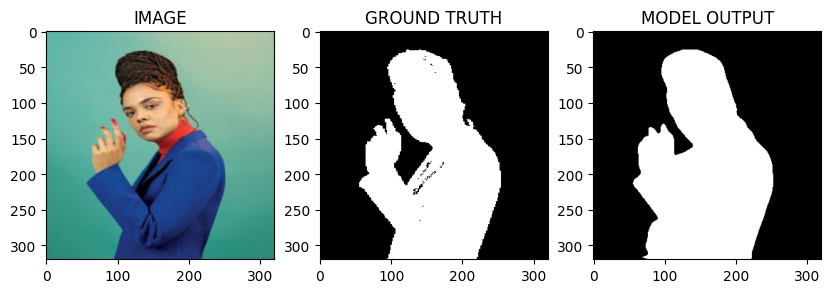

In [71]:
# This retrieves the image and corresponding ground truth mask from the validation dataset at the index
image, mask = validset[idx]
# Unsqueeze changes the shape from (C, H, W) to (1, C, H, W), where 1 represents a batch size of 1.
logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)
# The sigmoid function converts the logits into probabilities in the range of [0, 1].
pred_mask = torch.sigmoid(logits_mask)
# Pixels with a probability greater than 0.5 are classified as 1.
# * 1.0: Converts the boolean mask (True or False) to a binary mask with values 1.0 and 0.0 by multiplying by 1.0
pred_mask = (pred_mask > 0.5) * 1.0

# pred_mask.detach(): Detaches the predicted mask from the computation graph, ensuring it no longer tracks gradients.
# .cpu(): Moves the predicted mask from the GPU back to the CPU, so it can be processed by non-GPU functions like plotting.
# .squeeze(0): Removes the batch dimension, changing the shape from (1, C, H, W) back to (C, H, W) for visualization.
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))